# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [1]:
# Imports dependecies
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: Import the OHLCV dataset into a Pandas DataFrame.

In [2]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [3]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:,["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [99]:
# Set the short window and long window
short_window = 50
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2016-01-07 15:30:00,18.84,-0.002647,19.8578,20.0461,-1.0,0.002647
2016-01-07 15:45:00,18.78,-0.003185,19.8184,20.0365,-1.0,0.003185
2016-01-08 09:30:00,18.92,0.007455,19.7814,20.0278,1.0,-0.007455
2016-01-08 09:45:00,18.90,-0.001057,19.7448,20.0188,-1.0,-0.001057
2016-01-08 10:00:00,18.87,-0.001587,19.7074,20.0114,-1.0,0.001587


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,31.2848,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,31.3480,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,31.4132,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,31.4768,30.57495,-1.0,-0.000896


In [100]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2016-01-07 15:30:00,18.84,-0.002647,19.8578,20.0461,-1.0,0.002647
2016-01-07 15:45:00,18.78,-0.003185,19.8184,20.0365,-1.0,0.003185
2016-01-08 09:30:00,18.92,0.007455,19.7814,20.0278,1.0,-0.007455
2016-01-08 09:45:00,18.90,-0.001057,19.7448,20.0188,-1.0,-0.001057
2016-01-08 10:00:00,18.87,-0.001587,19.7074,20.0114,-1.0,0.001587


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,31.2848,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,31.3480,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,31.4132,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,31.4768,30.57495,-1.0,-0.000896


In [101]:
# Checkin the values of 'buy/sell'
signals_df["Signal"].value_counts()

Signal
 1.0    2076
-1.0    1603
Name: count, dtype: int64

In [102]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2016-01-07 15:30:00,18.84,-0.002647,19.8578,20.0461,-1.0,NaN
2016-01-07 15:45:00,18.78,-0.003185,19.8184,20.0365,-1.0,0.003185
2016-01-08 09:30:00,18.92,0.007455,19.7814,20.0278,1.0,-0.007455
2016-01-08 09:45:00,18.90,-0.001057,19.7448,20.0188,-1.0,-0.001057
2016-01-08 10:00:00,18.87,-0.001587,19.7074,20.0114,-1.0,0.001587


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,31.2232,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,31.2848,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,31.3480,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,31.4132,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,31.4768,30.57495,-1.0,-0.000896


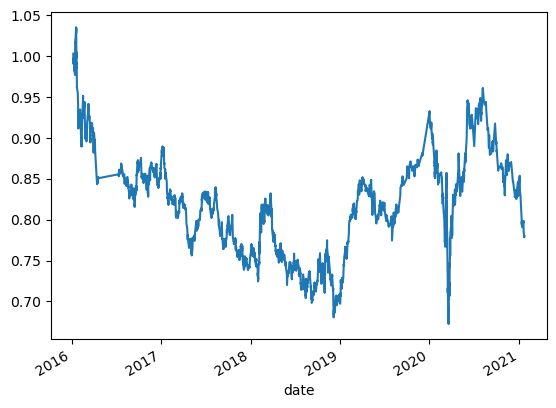

In [103]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()
# Save plot in the images folder.
plt.savefig('Images/Strat_returns2.png')

## Step 3: Split the data into training and testing datasets.
Creating 2 different sets of training data. The first set will be run against 3 months of data and the second will 6 months of training data

In [104]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2016-01-07 15:45:00,19.8578,20.0461
2016-01-08 09:30:00,19.8184,20.0365
2016-01-08 09:45:00,19.7814,20.0278
2016-01-08 10:00:00,19.7448,20.0188
2016-01-08 10:45:00,19.7074,20.0114


In [105]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

Signal
 1.0    2076
-1.0    1603
Name: count, dtype: int64

In [106]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2016-01-07 15:45:00


In [107]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)
# Creating a second trainging period
training_end2 = X.index.min() + DateOffset(months=6)
# Display the training end date
print(training_end)
print(training_end2)

2016-04-07 15:45:00
2016-07-07 15:45:00


In [108]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]
# Generating the second training set
X_train2 = X.loc[training_begin:training_end2]
y_train2 = y.loc[training_begin:training_end2]

# Review the X_train DataFrame
display(X_train)
display(X_train2)

,SMA_Fast,SMA_Slow
date,,
2016-01-07 15:45:00,19.85780,20.04610
2016-01-08 09:30:00,19.81840,20.03650
2016-01-08 09:45:00,19.78140,20.02780
2016-01-08 10:00:00,19.74480,20.01880
2016-01-08 10:45:00,19.70740,20.01140
...,...,...
2016-03-31 15:45:00,20.56640,20.08040
2016-04-01 09:45:00,20.57300,20.09560
2016-04-04 11:30:00,20.57120,20.10780


,SMA_Fast,SMA_Slow
date,,
2016-01-07 15:45:00,19.85780,20.04610
2016-01-08 09:30:00,19.81840,20.03650
2016-01-08 09:45:00,19.78140,20.02780
2016-01-08 10:00:00,19.74480,20.01880
2016-01-08 10:45:00,19.70740,20.01140
...,...,...
2016-04-15 15:15:00,20.72038,20.42449
2016-04-18 13:00:00,20.72478,20.44309
2016-04-18 13:15:00,20.73258,20.46649


In [109]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]
# Generate the 2nd X_test and y_test DataFrames
X_test2 = X.loc[training_end2+DateOffset(hours=1):]
y_test2 = y.loc[training_end2+DateOffset(hours=1):]
# Review the X_test DataFrame
display(X_test.head())
display(X_test2.head())

,SMA_Fast,SMA_Slow
date,,
2016-04-13 15:00:00,20.57478,20.14899
2016-04-13 15:45:00,20.58758,20.16849
2016-04-14 09:45:00,20.60018,20.18809
2016-04-14 10:00:00,20.60978,20.20629
2016-04-14 10:30:00,20.61818,20.22429


,SMA_Fast,SMA_Slow
date,,
2016-07-11 12:15:00,20.74918,20.52309
2016-07-11 13:00:00,20.75178,20.54119
2016-07-12 15:00:00,20.75778,20.55579
2016-07-12 15:15:00,20.76678,20.57159
2016-07-12 15:45:00,20.77998,20.58729


In [110]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)
X_scaler2 = scaler.fit(X_train2)
# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
# Transform the X_train and X_test DataFrames using the X_scaler 2nd set
X_train_scaled2 = X_scaler.transform(X_train2)
X_test_scaled2 = X_scaler.transform(X_test2)

### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [111]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()

# 2nd model with 6months data
svm_model2 = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
svm_model2 = svm_model2.fit(X_train_scaled2, y_train2)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_pred2 = svm_model2.predict(X_test_scaled2)
# Review the model's predicted values
display(svm_pred[:3])
display(svm_pred2[:3])

array([-1., -1., -1.])

array([-1., -1., -1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [112]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
svm_testing_report2 = classification_report(y_test2, svm_pred2)
# Print the classification report
print('The Classification report for SVM model 1: ')
print(svm_testing_report)
print('The Classification report for SVM model 2: ')
print(svm_testing_report2)

The Classification report for SVM model 1: 
              precision    recall  f1-score   support

        -1.0       0.40      0.03      0.05      1496
         1.0       0.56      0.97      0.71      1929

    accuracy                           0.56      3425
   macro avg       0.48      0.50      0.38      3425
weighted avg       0.49      0.56      0.42      3425

The Classification report for SVM model 2: 
              precision    recall  f1-score   support

        -1.0       0.36      0.02      0.05      1484
         1.0       0.56      0.97      0.71      1921

    accuracy                           0.56      3405
   macro avg       0.46      0.50      0.38      3405
weighted avg       0.48      0.56      0.42      3405



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [113]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df2 = pd.DataFrame(index=X_test2.index)
# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred
predictions_df2['Predicted'] = svm_pred2
# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df2['Actual Returns'] = signals_df['Actual Returns']
# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']
predictions_df2['Strategy Returns'] = signals_df['Strategy Returns']
# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())
display(predictions_df2.head())

,Predicted,Actual Returns,Strategy Returns
date,,,
2016-04-13 15:00:00,-1.0,0.041955,-0.041955
2016-04-13 15:45:00,-1.0,-0.000474,-0.000474
2016-04-14 09:45:00,-1.0,-0.006161,0.006161
2016-04-14 10:00:00,-1.0,-0.000477,0.000477
2016-04-14 10:30:00,-1.0,0.004294,-0.004294


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,-0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


,Predicted,Actual Returns,Strategy Returns
date,,,
2016-07-11 12:15:00,-1.0,-0.005701,0.005701
2016-07-11 13:00:00,-1.0,0.002867,-0.002867
2016-07-12 15:00:00,-1.0,0.009528,0.009528
2016-07-12 15:15:00,-1.0,0.000000,0.000000
2016-07-12 15:45:00,-1.0,-0.000472,-0.000472


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

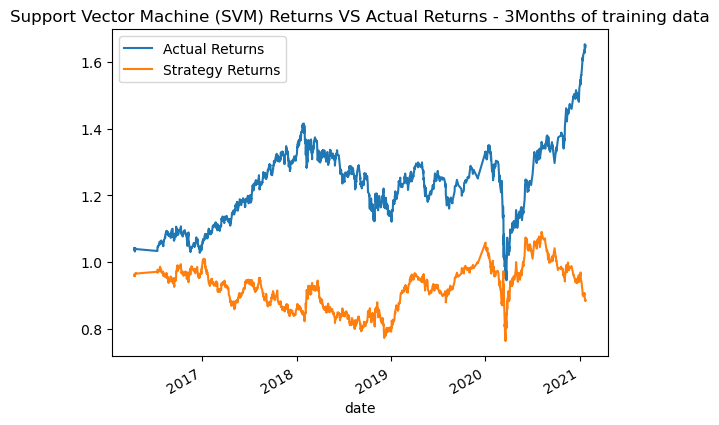

In [114]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[['Actual Returns', 'Strategy Returns']]).cumprod().plot()
# Save plot in the images folder.
plt.title('Support Vector Machine (SVM) Returns VS Actual Returns - 3Months of training data')
plt.savefig('Images/svm_model_2.png')

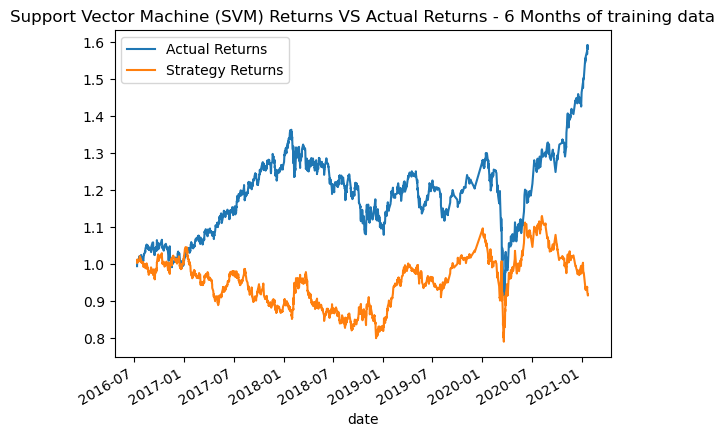

In [115]:
# Plot the actual returns versus the strategy returns for 2nd set of data
(1 + predictions_df2[['Actual Returns', 'Strategy Returns']]).cumprod().plot()
# Save plot in the images folder.
plt.title('Support Vector Machine (SVM) Returns VS Actual Returns - 6 Months of training data')
plt.savefig('Images/svm_model2_2.png')

## Tune the Baseline Trading Algorithm
In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

### Answer the following question: What impact resulted from increasing or decreasing the training window?

I made two SVM models... One with a training window with 3 months(SVM1) and one with 6 months (SVM2). The second model was slightly better after reviewing the classification report under precision and accuracy. However, not enough to be called successful. 

### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [116]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
lr_model = LogisticRegression()
lr_model2 = LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [117]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2016-01-28 15:45:00,18.75,0.001603,18.7075,18.43285,1.0,0.001603
2016-01-29 09:45:00,18.99,0.012800,18.7750,18.43435,1.0,0.012800
2016-01-29 10:00:00,19.10,0.005793,18.8900,18.43755,1.0,0.005793
2016-01-29 11:00:00,19.05,-0.002618,18.9725,18.43885,-1.0,-0.002618
2016-01-29 12:00:00,19.08,0.001575,19.0550,18.44065,1.0,-0.001575


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


In [118]:
# Fit the model using the training data
lr_model = lr_model.fit(X_train_scaled, y_train)
# fittiing second model
lr_model2 = lr_model2.fit(X_train_scaled2, y_train2)

# Use the testing dataset to generate the predictions for the new model
pred = lr_model.predict(X_test_scaled)
pred2 = lr_model2.predict(X_test_scaled2)
# Review the model's predicted values
pred[:3]


array([1., 1., 1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [119]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_model_testing_report = classification_report(y_test, pred)
lr_model_testing_report2 = classification_report(y_test2, pred2)

# Print the classification report
print("Classification Report for LogisticRegression Model 1")
print(lr_model_testing_report)
print("Classification Report for LogisticRegression Model 2")
print(lr_model_testing_report2)


Classification Report for LogisticRegression Model 1
              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61      1496
         1.0       0.25      0.00      0.00      1929

    accuracy                           0.44      3425
   macro avg       0.34      0.50      0.30      3425
weighted avg       0.33      0.44      0.27      3425

Classification Report for LogisticRegression Model 2
              precision    recall  f1-score   support

        -1.0       0.44      1.00      0.61      1484
         1.0       0.00      0.00      0.00      1921

    accuracy                           0.44      3405
   macro avg       0.22      0.50      0.30      3405
weighted avg       0.19      0.44      0.26      3405



In [120]:
# Create a new empty predictions DataFrame:
predictions_df_new = pd.DataFrame(index=y_test.index)
predictions_df_new2 = pd.DataFrame(index=y_test2.index)
# Create a predictions DataFrame
predictions_df_new['Predicted'] = pred
predictions_df_new2['Predicted'] = pred2
# Add the SVM model predictions to the DataFrame
predictions_df_new['SVM Predicted'] = svm_pred
predictions_df_new2['SVM Predicted'] = svm_pred2
# Add the actual returns to the DataFrame
predictions_df_new['Actual Returns'] =  signals_df["Actual Returns"]
predictions_df_new2['Actual Returns'] =  signals_df["Actual Returns"]
# Add the strategy returns to the DataFrame
predictions_df_new['Strategy Returns'] = predictions_df_new["Actual Returns"] * predictions_df_new['Predicted']
predictions_df_new2['Strategy Returns'] = predictions_df_new2["Actual Returns"] * predictions_df_new2['Predicted']
# Review the DataFrame
display(predictions_df_new.head())
display(predictions_df_new.tail())
display(predictions_df_new2.head())
display(predictions_df_new2.tail())

,Predicted,SVM Predicted,Actual Returns,Strategy Returns
date,,,,
2016-04-13 15:00:00,1.0,-1.0,0.041955,0.041955
2016-04-13 15:45:00,1.0,-1.0,-0.000474,-0.000474
2016-04-14 09:45:00,1.0,-1.0,-0.006161,-0.006161
2016-04-14 10:00:00,1.0,-1.0,-0.000477,-0.000477
2016-04-14 10:30:00,-1.0,-1.0,0.004294,-0.004294


,Predicted,SVM Predicted,Actual Returns,Strategy Returns
date,,,,
2021-01-22 09:30:00,-1.0,1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,1.0,-0.000896,0.000896


,Predicted,SVM Predicted,Actual Returns,Strategy Returns
date,,,,
2016-07-11 12:15:00,-1.0,-1.0,-0.005701,0.005701
2016-07-11 13:00:00,-1.0,-1.0,0.002867,-0.002867
2016-07-12 15:00:00,-1.0,-1.0,0.009528,-0.009528
2016-07-12 15:15:00,-1.0,-1.0,0.000000,-0.000000
2016-07-12 15:45:00,-1.0,-1.0,-0.000472,0.000472


,Predicted,SVM Predicted,Actual Returns,Strategy Returns
date,,,,
2021-01-22 09:30:00,-1.0,1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,1.0,0.002405,-0.002405
2021-01-22 13:45:00,-1.0,1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,1.0,-0.000896,0.000896


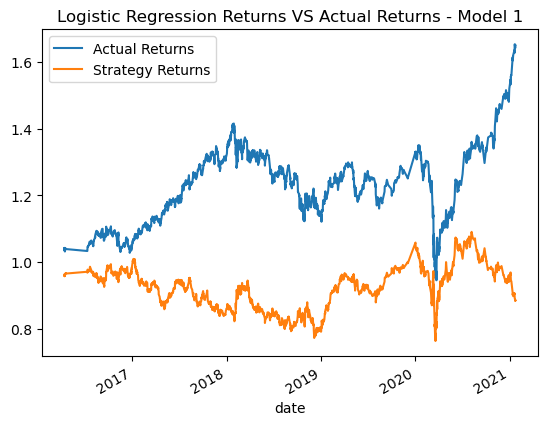

In [122]:
# Plot the actual returns versus the strategy returns of the first model
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Save plot in the images folder.
plt.title('Logistic Regression Returns VS Actual Returns - Model 1')
plt.savefig('Images/lr_model1_2.png')

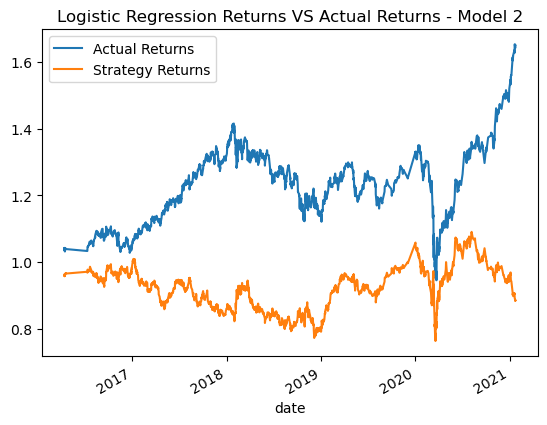

In [123]:
# Plot the actual returns versus the strategy returns of the econd model
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Save plot in the images folder.
plt.title('Logistic Regression Returns VS Actual Returns - Model 2')
plt.savefig('Images/lr_model2_2.png')

## Creating a new model using DecisionTreeClassifier 

In [124]:
# Import a new classifier from SKLearn
from sklearn import tree

# Initiate the model instance
tree_model = tree.DecisionTreeClassifier()
tree_model2 = tree.DecisionTreeClassifier()
# Fit the model using the training data
tree_model = tree_model.fit(X_train_scaled, y_train)
tree_model2 = tree_model2.fit(X_train_scaled2, y_train2)
# Use the testing dataset to generate the predictions for the new model
tree_pred =  tree_model.predict(X_test_scaled) 
tree_pred2 =  tree_model2.predict(X_test_scaled2)
# Calculating the accuracy score
print('Classification Report 1 of the DecisionTree model:')
print(classification_report(y_test, tree_pred))
print('CLassification Report 2 of the DecisionTree model:')
print(classification_report(y_test2, tree_pred2))

Classification Report 1 of the DecisionTree model:
              precision    recall  f1-score   support

        -1.0       0.44      0.99      0.61      1496
         1.0       0.62      0.02      0.03      1929

    accuracy                           0.44      3425
   macro avg       0.53      0.50      0.32      3425
weighted avg       0.54      0.44      0.28      3425

CLassification Report 2 of the DecisionTree model:
              precision    recall  f1-score   support

        -1.0       0.44      0.99      0.61      1484
         1.0       0.60      0.02      0.03      1921

    accuracy                           0.44      3405
   macro avg       0.52      0.50      0.32      3405
weighted avg       0.53      0.44      0.28      3405



In [125]:
# Create a new empty predictions DataFrame:

# Create a predictions DataFrame
decision_tree_df = pd.DataFrame(index=X_test.index)
decision_tree_df2 = pd.DataFrame(index=X_test2.index)
# Add the SVM model predictions to the DataFrame
decision_tree_df['Predicted'] = tree_pred
decision_tree_df2['Predicted'] = tree_pred2
# Add the actual returns to the DataFrame
decision_tree_df['Actual Returns'] = signals_df['Actual Returns']
decision_tree_df2['Actual Returns'] = signals_df['Actual Returns']
# Add the strategy returns to the DataFrame
decision_tree_df['Strategy Returns'] = decision_tree_df['Actual Returns']  * decision_tree_df['Predicted']
decision_tree_df2['Strategy Returns'] = decision_tree_df2['Actual Returns']  * decision_tree_df2['Predicted']



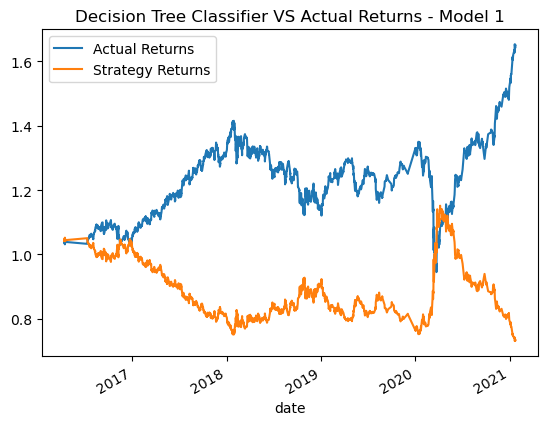

In [126]:
# Plot the actual returns versus the strategy returns
(1 + decision_tree_df[['Actual Returns' , 'Strategy Returns']]).cumprod().plot()
plt.title('Decision Tree Classifier VS Actual Returns - Model 1')
plt.savefig('Images/tree_model_vs_actual1_2.png')

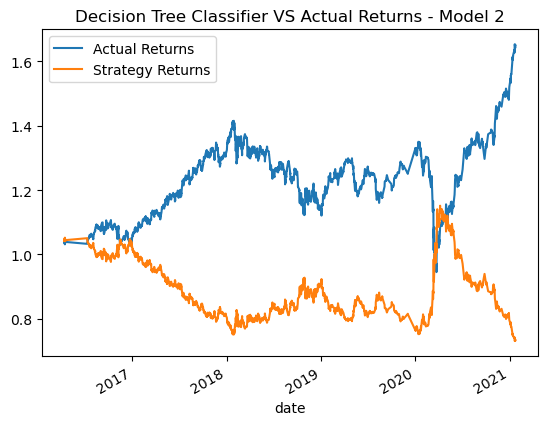

In [127]:
# Plot the actual returns versus the strategy returns for second model
(1 + decision_tree_df[['Actual Returns' , 'Strategy Returns']]).cumprod().plot()
plt.title('Decision Tree Classifier VS Actual Returns - Model 2')
plt.savefig('Images/tree_model_vs_actual2_2.png')